# Deep learning para predecir precio de productos de supermercado

## Resumen

Creación de una red neuronal paso a paso con TensorFlow 2 y Keras, con el objetivo de entrenarla con información de productos de supermercado y poder así predecir precios de productos desconocidos.

La idea surge como curiosidad para contestar a esto: sabiendo cuánto vale el hummus y cuánto vale el chocolate en un supermercado, **¿Cuánto valdría el hummus de chocolate?** ¿Cómo de buena puede ser una predicción del precio de productos no conocidos por la red neuronal?

Los datos iniciales no son todo lo buenos que nos gustaría, al contar solo para el entrenamiento con esta info de cada producto:
- Nombre del producto.
- Precio.
- Tipo de envase.
- Medida (en kilogramos, metros, litros o unidades).
- Si es agua o no.
- Si es para +18 años.

## Ejemplo de resultados obtenidos para productos que no existen:

- hummus de chocolate, tarrina 240gr, 1.95 euros
- hummus de chocolate hacendado, tarrina 240gr, 1.52 euros
- hummus de chocolate nestlé, tarrina 240gr, 2.27 euros
* Hacendado el más barato (:

## Disclaimer y trabajo futuro

Es la primera red neuronal que hago, seguro que hay muchas cosas que se pueden mejorar y seguiré aprendiendo.

Trabajo futuro (ToDo):
- Comparar resultados eliminando los productos anómalos que se "salen" de las gráficas de distribución (palillos en cajas de 800, jamón de 300 euros, etc...) 
- Comparar resultados normalizando / no normalizando los datos de entrada.
- Comparar resultados preprocesando los nombres de los productos (ideas: quitar números, quitar palabras "de", "la", "el"...).
- Hacer pruebas con diferentes meta parámetros de la red neuronal.
- Evitar el overfitting de la versión actual.
- Aplicar *Data augmentation*, para crear productos derivados en el set de entrenamiento (ejemplo: crear productos "pack" con mayor peso y mayor precio).
- Tener en cuenta la semántica de las palabras del nombre del producto. Ahora mismo por ejemplo 'casera' y 'caseras' son 2 palabras diferentes en la codificación *one-hot encoding* que he usado. Idea: utilizar técnica *word embedding* con una red preentrenada que conozca semántica de las palabras.

In [0]:
# Conectamos nuestro google drive, que es donde estará alojado el fichero '.csv' de productos.
from google.colab import drive
drive.mount('/content/drive')

In [349]:
import pandas as pd
import numpy as np
path = "./drive/My Drive/Colab Notebooks/products_mercadona_2018.csv"
raw_dataset = pd.read_csv(path, sep=';', usecols=['id', 'is_water', 'packaging', 'requires_age_check', 'display_name', 'unit_size', 'unit_price', 'size_format'])
# Nota: la columna "id" no es de tipo int sino que algunos valores son float.
raw_dataset.tail()

,id,is_water,requires_age_check,packaging,display_name,unit_size,unit_price,size_format
6400,39696.0,False,False,Brick,Zumo de pomelo Hacendado,1.00,1.30,l
6401,39301.0,False,False,Botella,Zumo de tomate Sanflavino,0.60,1.99,l
6402,39395.0,False,False,Pack-4,Zumo de tomate Hacendado,0.80,1.15,l
6403,39922.0,False,False,Brick,Zumo de manzana selección Hacendado,1.00,1.36,l
6404,39390.0,False,False,Botella,Zumo de tomate picante Big Tom,0.25,1.65,l


In [183]:
raw_dataset.dtypes

id                    float64
is_water                 bool
requires_age_check       bool
packaging              object
display_name           object
unit_size             float64
unit_price            float64
size_format            object
dtype: object

In [0]:
dataset = raw_dataset.copy() # hacer una copia de los datos, trabajaremos sobre la copia.

In [0]:
dataset['packaging'] = dataset['packaging'].str.lower() # Pasar a minúsculas.
dataset['display_name'] = dataset['display_name'].str.lower()

dataset['is_water'] = dataset['is_water'].astype(int) # convertir bool en int.
dataset['requires_age_check'] = dataset['requires_age_check'].astype(int)

In [261]:
print(dataset.isna().sum()) # contar datos que faltan en el dataset (a null).

id                      0
is_water                0
requires_age_check      0
packaging             564
display_name            0
unit_size              59
unit_price              0
size_format             0
dtype: int64


In [262]:
dataset[dataset['unit_size'].isnull()].tail(10) # mostramos productos con unit_size=null.
# Parece que son productos de peso variable.

,id,is_water,requires_age_check,packaging,display_name,unit_size,unit_price,size_format
2589,24324.0,0,0,pieza,merluza del cabo mascato sin cabeza congelada,NaN,3.60,kg
2591,24249.0,0,0,paquete,anillas de pota profand congeladas,NaN,3.75,kg
2592,24208.0,0,0,paquete,pulpo crudo profand congelado,NaN,16.84,kg
2593,24291.0,0,0,paquete,chipirón puntilla profand congelado,NaN,3.75,kg
2594,24266.0,0,0,paquete,pulpo cocido troceado profand congelado,NaN,6.95,kg
2595,62029.0,0,0,paquete,lenguado entero hacendado congelado,NaN,5.90,kg
2596,62483.0,0,0,pieza,filete de merluza chile europacífico sin piel ...,NaN,5.68,kg
2597,62484.0,0,0,pieza,filete de merluza chile europacífico con piel ...,NaN,5.01,kg
4418,69827.0,0,0,granel,judía verde plana,NaN,197.01,kg
5489,62191.0,0,0,paquete,filetes de panga ultracongelados,NaN,3.99,kg


In [263]:
dataset[dataset['packaging'].isnull()].tail(10) # mostramos productos con packaging=null.
# Parece que hay productos de horno que realmente no deben tener packaging, y otros 
# productos como 'smoothie' que realmente van en una especie de bolsa.

,id,is_water,requires_age_check,packaging,display_name,unit_size,unit_price,size_format
6054,63585.0,0,0,NaN,pizza margarita hacendado,0.34,1.85,kg
6056,63514.0,0,0,NaN,pizza jamón y queso sin gluten y sin lactosa h...,0.42,2.99,kg
6057,63544.0,0,0,NaN,rosca jamón serrano y queso emmental hacendado,0.42,2.80,kg
6058,63532.0,0,0,NaN,quiche verduras hacendado con calabacín y ques...,0.39,1.99,kg
6059,63545.0,0,0,NaN,"rosca lomo, bacón y queso emmental hacendado",0.45,2.80,kg
6060,63526.0,0,0,NaN,quiche york y bacón hacendado,0.38,1.99,kg
6352,3944.0,0,0,NaN,"smoothie mascletá verdifresh con naranja, zana...",0.25,1.35,kg
6357,3941.0,0,0,NaN,"smoothie menorca verdifresh con piña, coco, le...",0.25,1.35,kg
6358,3953.0,0,0,NaN,"smoothie chupinazo verdifresh con remolacha, p...",0.25,1.35,kg
6359,3939.0,0,0,NaN,smoothie belleza flamenca verdifresh con framb...,0.25,1.35,kg


In [0]:
# Decisiones sobre los datos incompletos:
# dataset.pop('packaging') # 1.A. Quitar columna packaging.
dataset[['packaging']] = dataset[['packaging']].fillna('otro') # 1.B. Crear categoría "otro" en packaging=null.
dataset = dataset.dropna() # 2. Borrar filas en las que falta unit_size.

In [265]:
print(dataset.isna().sum())

id                    0
is_water              0
requires_age_check    0
packaging             0
display_name          0
unit_size             0
unit_price            0
size_format           0
dtype: int64


In [0]:
dataset = dataset.reset_index() # resetear index después de quitar algunas filas.

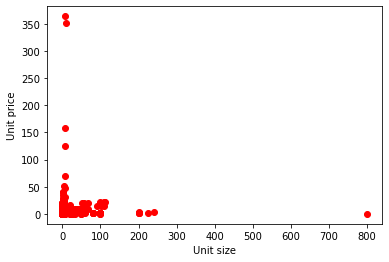

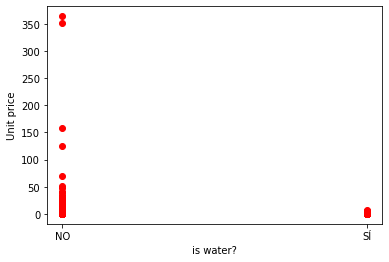

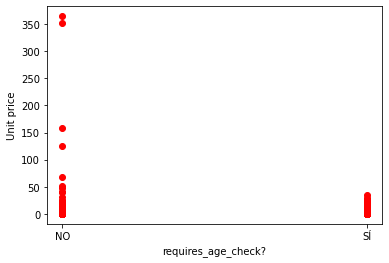

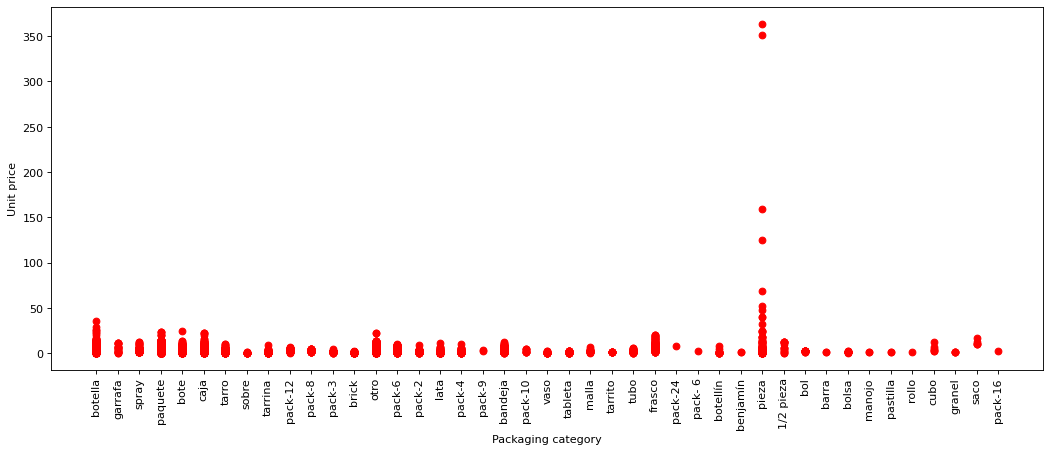

In [267]:
# representamos gráficamente para saber qué forma tienen los datos.
import matplotlib.pyplot as plt

# unit_size - unit_price
plt.xlabel('Unit size')
plt.ylabel('Unit price')
plt.scatter(dataset['unit_size'], dataset['unit_price'], marker='o', color='red')
plt.show()

# is_water - unit_price
plt.xlabel('is water?')
plt.ylabel('Unit price')
plt.xticks([0, 1], ['NO', 'SÍ'])
plt.scatter(dataset['is_water'], dataset['unit_price'], marker='o', color='red')
plt.show()

# requires_age_check - unit_price
plt.xlabel('requires_age_check?')
plt.ylabel('Unit price')
plt.xticks([0, 1], ['NO', 'SÍ'])
plt.scatter(dataset['requires_age_check'], dataset['unit_price'], marker='o', color='red')
plt.show()

# packaging - unit_price
plt.figure(figsize=(16, 6), dpi=80)
plt.xlabel('Packaging category')
plt.ylabel('Unit price')
plt.xticks(rotation='vertical')
# plt.scatter(dataset['unit_size'], dataset['unit_price'], marker='o', color='black')
plt.scatter(dataset['packaging'], dataset['unit_price'], marker='o', color='red')

plt.show()

In [268]:
dataset[dataset['unit_price'] == dataset['unit_price'].max()] # ver valores máximos. ¿Son anómalos?

,index,id,is_water,requires_age_check,packaging,display_name,unit_size,unit_price,size_format
2238,2238,58297.0,0,0,pieza,jamón de bellota ibérico covap,7.5,363.75,kg


In [269]:
dataset[dataset['unit_size'] == dataset['unit_size'].max()] # ver valores máximos. ¿Son anómalos?

,index,id,is_water,requires_age_check,packaging,display_name,unit_size,unit_price,size_format
5000,5058,49321.0,0,0,caja,palillos redondos,800.0,0.8,ud


In [270]:
# One-hot encoding para la columna 'size_format'.
size_format = dataset['size_format']
list_size_formats = np.unique(size_format)
list_size_formats

array(['kg', 'l', 'm', 'ud'], dtype=object)

In [271]:
for i in list_size_formats:
  dataset['size_format__' + i] = (size_format == i)*1.0
dataset.tail()

,index,id,is_water,requires_age_check,packaging,display_name,unit_size,unit_price,size_format,size_format__kg,size_format__l,size_format__m,size_format__ud
6341,6400,39696.0,0,0,brick,zumo de pomelo hacendado,1.00,1.30,l,0.0,1.0,0.0,0.0
6342,6401,39301.0,0,0,botella,zumo de tomate sanflavino,0.60,1.99,l,0.0,1.0,0.0,0.0
6343,6402,39395.0,0,0,pack-4,zumo de tomate hacendado,0.80,1.15,l,0.0,1.0,0.0,0.0
6344,6403,39922.0,0,0,brick,zumo de manzana selección hacendado,1.00,1.36,l,0.0,1.0,0.0,0.0
6345,6404,39390.0,0,0,botella,zumo de tomate picante big tom,0.25,1.65,l,0.0,1.0,0.0,0.0


In [272]:
# One-hot encoding para la columna 'packaging'.
packaging = dataset['packaging']
np.unique(packaging)

array(['1/2 pieza', 'bandeja', 'barra', 'benjamín', 'bol', 'bolsa',
       'bote', 'botella', 'botellín', 'brick', 'caja', 'cubo', 'frasco',
       'garrafa', 'granel', 'lata', 'malla', 'manojo', 'otro', 'pack- 6',
       'pack-10', 'pack-12', 'pack-16', 'pack-2', 'pack-24', 'pack-3',
       'pack-4', 'pack-6', 'pack-8', 'pack-9', 'paquete', 'pastilla',
       'pieza', 'rollo', 'saco', 'sobre', 'spray', 'tableta', 'tarrina',
       'tarrito', 'tarro', 'tubo', 'vaso'], dtype=object)

In [273]:
# Detectado un dato anómalo ('pack- 6' en lugar de 'pack-6'). Lo corregimos.
dataset['packaging'] = dataset['packaging'].replace(['pack- 6'], 'pack-6')
packaging = dataset['packaging']
list_packagings = np.unique(dataset['packaging'])
list_packagings

array(['1/2 pieza', 'bandeja', 'barra', 'benjamín', 'bol', 'bolsa',
       'bote', 'botella', 'botellín', 'brick', 'caja', 'cubo', 'frasco',
       'garrafa', 'granel', 'lata', 'malla', 'manojo', 'otro', 'pack-10',
       'pack-12', 'pack-16', 'pack-2', 'pack-24', 'pack-3', 'pack-4',
       'pack-6', 'pack-8', 'pack-9', 'paquete', 'pastilla', 'pieza',
       'rollo', 'saco', 'sobre', 'spray', 'tableta', 'tarrina', 'tarrito',
       'tarro', 'tubo', 'vaso'], dtype=object)

In [274]:
for i in list_packagings:
  dataset['packaging__' + i] = (packaging == i)*1.0
dataset.tail()

,index,id,is_water,requires_age_check,packaging,display_name,unit_size,unit_price,size_format,size_format__kg,size_format__l,size_format__m,size_format__ud,packaging__1/2 pieza,packaging__bandeja,packaging__barra,packaging__benjamín,packaging__bol,packaging__bolsa,packaging__bote,packaging__botella,packaging__botellín,packaging__brick,packaging__caja,packaging__cubo,packaging__frasco,packaging__garrafa,packaging__granel,packaging__lata,packaging__malla,packaging__manojo,packaging__otro,packaging__pack-10,packaging__pack-12,packaging__pack-16,packaging__pack-2,packaging__pack-24,packaging__pack-3,packaging__pack-4,packaging__pack-6,packaging__pack-8,packaging__pack-9,packaging__paquete,packaging__pastilla,packaging__pieza,packaging__rollo,packaging__saco,packaging__sobre,packaging__spray,packaging__tableta,packaging__tarrina,packaging__tarrito,packaging__tarro,packaging__tubo,packaging__vaso
6341,6400,39696.0,0,0,brick,zumo de pomelo hacendado,1.00,1.30,l,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6342,6401,39301.0,0,0,botella,zumo de tomate sanflavino,0.60,1.99,l,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6343,6402,39395.0,0,0,pack-4,zumo de tomate hacendado,0.80,1.15,l,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6344,6403,39922.0,0,0,brick,zumo de manzana selección hacendado,1.00,1.36,l,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6345,6404,39390.0,0,0,botella,zumo de tomate picante big tom,0.25,1.65,l,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [275]:
dataset.pop('size_format') # quitar columna "size format".
dataset.pop('packaging') # quitar columna "packaging".
dataset.pop('id')
dataset.tail(10)

,index,is_water,requires_age_check,display_name,unit_size,unit_price,size_format__kg,size_format__l,size_format__m,size_format__ud,packaging__1/2 pieza,packaging__bandeja,packaging__barra,packaging__benjamín,packaging__bol,packaging__bolsa,packaging__bote,packaging__botella,packaging__botellín,packaging__brick,packaging__caja,packaging__cubo,packaging__frasco,packaging__garrafa,packaging__granel,packaging__lata,packaging__malla,packaging__manojo,packaging__otro,packaging__pack-10,packaging__pack-12,packaging__pack-16,packaging__pack-2,packaging__pack-24,packaging__pack-3,packaging__pack-4,packaging__pack-6,packaging__pack-8,packaging__pack-9,packaging__paquete,packaging__pastilla,packaging__pieza,packaging__rollo,packaging__saco,packaging__sobre,packaging__spray,packaging__tableta,packaging__tarrina,packaging__tarrito,packaging__tarro,packaging__tubo,packaging__vaso
6336,6395,0,0,néctar de mango hacendado sin azúcares añadidos,1.00,0.76,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6337,6396,0,0,néctar de pomelo hacendado sin azúcares añadidos,1.00,1.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6338,6397,0,0,néctar guayaba hacendado sin azúcares añadidos,1.00,0.90,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6339,6398,0,0,zumo de tomate hacendado,1.00,0.65,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6340,6399,0,0,néctar de pera hacendado sin azúcares añadidos,1.00,0.90,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6341,6400,0,0,zumo de pomelo hacendado,1.00,1.30,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6342,6401,0,0,zumo de tomate sanflavino,0.60,1.99,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6343,6402,0,0,zumo de tomate hacendado,0.80,1.15,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6344,6403,0,0,zumo de manzana selección hacendado,1.00,1.36,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6345,6404,0,0,zumo de tomate picante big tom,0.25,1.65,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# TODO: estos 2 métodos no se usan actualmente.
# quitar conectores en display_name.
def remove_some_words(sentence):
  stopwords = ['de', 'los', 'las', 'el', 'la', 'del'] # TODO revisar esta lista
  sentence = sentence.split()

  resultwords  = [word for word in sentence if word not in stopwords]
  result = ' '.join(resultwords)

  return result

# aproximación. Quitar "s" al final de las palabras (chapuza :D)
def remove_last_s(sentence):
  sentence = sentence.split()

  resultwords  = map(lambda x: x[:-1] if (x[-1] == 's') else x, sentence)
  result = ' '.join(resultwords)

  return result

# dataset['display_name'] = dataset['display_name'].apply(remove_some_words)

# descartamos remove_last_s(), obtiene peores resultados.
# dataset['display_name'] = dataset['display_name'].apply(remove_last_s) # ahorro de 400 palabras diferentes aprox.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

In [278]:
X = vectorizer.fit_transform(dataset['display_name'])
X

<6346x4423 sparse matrix of type '<class 'numpy.int64'>'
	with 33389 stored elements in Compressed Sparse Row format>

In [0]:
analyze = vectorizer.build_analyzer()

In [280]:
analyze("hummus de chocolate") == (['hummus', 'de', 'chocolate'])

True

In [281]:
words = vectorizer.get_feature_names()
words

['01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '100',
 '100l',
 '101',
 '102',
 '103',
 '105',
 '106',
 '108',
 '109',
 '10l',
 '11',
 '110',
 '111',
 '12',
 '120',
 '13',
 '14',
 '140',
 '15',
 '150',
 '1557',
 '16',
 '17',
 '18',
 '185',
 '19',
 '1916',
 '1925',
 '1l',
 '1ªa',
 '1ªb',
 '1º',
 '20',
 '200',
 '2018',
 '21',
 '210',
 '22',
 '22l',
 '23',
 '24',
 '240',
 '246',
 '24h',
 '24k',
 '25',
 '250',
 '260',
 '27',
 '270',
 '28',
 '2º',
 '30',
 '300',
 '30l',
 '31',
 '316',
 '32',
 '323',
 '34',
 '35',
 '354',
 '36',
 '360',
 '37',
 '38',
 '39',
 '3l',
 '40',
 '400',
 '41',
 '415',
 '42',
 '43',
 '44',
 '443',
 '45',
 '450',
 '46',
 '47',
 '48',
 '49',
 '50',
 '500',
 '503',
 '50l',
 '51',
 '510',
 '52',
 '530',
 '535',
 '54',
 '55',
 '550',
 '565',
 '57',
 '58',
 '5l',
 '5º',
 '60',
 '600',
 '630',
 '634',
 '66',
 '660',
 '662',
 '671',
 '69',
 '6lr61',
 '70',
 '700',
 '70º',
 '73',
 '74',
 '740',
 '75',
 '752',
 '760',
 '77',
 '79',
 '7l',
 '7up',
 '80',

In [282]:
X.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [283]:
X.toarray().shape # obtener dimensiones

(6346, 4423)

In [284]:
vectorizer.vocabulary_.get('hummus')

2169

In [285]:
np.unique(vectorizer.transform(['Never seen before.']).toarray())

array([0])

In [286]:
 aux_data_frame_words = pd.DataFrame.from_records(X.toarray())
 aux_data_frame_words

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4383,4384,4385,4386,4387,4388,4389,4390,4391,4392,4393,4394,4395,4396,4397,4398,4399,4400,4401,4402,4403,4404,4405,4406,4407,4408,4409,4410,4411,4412,4413,4414,4415,4416,4417,4418,4419,4420,4421,4422
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6341,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6342,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6343,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6344,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [287]:
dataset_with_words = pd.concat([dataset, aux_data_frame_words], axis=1, sort=False)
len(dataset_with_words)

6346

TODO: Data augmentation para poner productos autogenerados a partir de multiplicar su cantidad y su precio con regla de tres.

In [288]:
dataset_with_words

,index,is_water,requires_age_check,display_name,unit_size,unit_price,size_format__kg,size_format__l,size_format__m,size_format__ud,packaging__1/2 pieza,packaging__bandeja,packaging__barra,packaging__benjamín,packaging__bol,packaging__bolsa,packaging__bote,packaging__botella,packaging__botellín,packaging__brick,packaging__caja,packaging__cubo,packaging__frasco,packaging__garrafa,packaging__granel,packaging__lata,packaging__malla,packaging__manojo,packaging__otro,packaging__pack-10,packaging__pack-12,packaging__pack-16,packaging__pack-2,packaging__pack-24,packaging__pack-3,packaging__pack-4,packaging__pack-6,packaging__pack-8,packaging__pack-9,packaging__paquete,...,4383,4384,4385,4386,4387,4388,4389,4390,4391,4392,4393,4394,4395,4396,4397,4398,4399,4400,4401,4402,4403,4404,4405,4406,4407,4408,4409,4410,4411,4412,4413,4414,4415,4416,4417,4418,4419,4420,4421,4422
0,0,0,0,aceite de oliva suave hacendado,1.00,3.90,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,aceite de oliva virgen extra hacendado,1.00,4.10,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,aceite de oliva intenso hacendado,1.00,3.90,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,aceite de oliva virgen hacendado,1.00,3.99,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,aceite de oliva intenso hacendado,3.00,10.95,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6341,6400,0,0,zumo de pomelo hacendado,1.00,1.30,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6342,6401,0,0,zumo de tomate sanflavino,0.60,1.99,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6343,6402,0,0,zumo de tomate hacendado,0.80,1.15,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6344,6403,0,0,zumo de manzana selección hacendado,1.00,1.36,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [289]:
dataset_with_words.pop('index')
dataset_with_words.pop('display_name')

0              aceite de oliva suave hacendado
1       aceite de oliva virgen extra hacendado
2            aceite de oliva intenso hacendado
3             aceite de oliva virgen hacendado
4            aceite de oliva intenso hacendado
                         ...                  
6341                  zumo de pomelo hacendado
6342                 zumo de tomate sanflavino
6343                  zumo de tomate hacendado
6344       zumo de manzana selección hacendado
6345            zumo de tomate picante big tom
Name: display_name, Length: 6346, dtype: object

In [0]:
train_dataset = dataset_with_words.sample(frac=0.8, random_state=0) # datos para entrenamiento

In [0]:
test_dataset = dataset_with_words.drop(train_dataset.index) # datos para test

In [292]:
# Extraemos la columna con los datos que queremos predecir (precio).
train_labels = train_dataset.pop('unit_price')
test_labels = test_dataset.pop('unit_price')
test_dataset

,is_water,requires_age_check,unit_size,size_format__kg,size_format__l,size_format__m,size_format__ud,packaging__1/2 pieza,packaging__bandeja,packaging__barra,packaging__benjamín,packaging__bol,packaging__bolsa,packaging__bote,packaging__botella,packaging__botellín,packaging__brick,packaging__caja,packaging__cubo,packaging__frasco,packaging__garrafa,packaging__granel,packaging__lata,packaging__malla,packaging__manojo,packaging__otro,packaging__pack-10,packaging__pack-12,packaging__pack-16,packaging__pack-2,packaging__pack-24,packaging__pack-3,packaging__pack-4,packaging__pack-6,packaging__pack-8,packaging__pack-9,packaging__paquete,packaging__pastilla,packaging__pieza,packaging__rollo,...,4383,4384,4385,4386,4387,4388,4389,4390,4391,4392,4393,4394,4395,4396,4397,4398,4399,4400,4401,4402,4403,4404,4405,4406,4407,4408,4409,4410,4411,4412,4413,4414,4415,4416,4417,4418,4419,4420,4421,4422
0,0,0,1.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0.75,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21,0,0,1.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24,0,0,0.28,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25,0,0,0.25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6328,0,0,1.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6329,0,0,1.20,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6334,0,0,1.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6336,0,0,1.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [293]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
is_water,5077.0,0.006894,0.082751,0.000000,0.0,0.0,0.0,1.0
requires_age_check,5077.0,0.064014,0.244802,0.000000,0.0,0.0,0.0,1.0
unit_size,5077.0,1.932121,14.824945,0.000375,0.2,0.5,1.0,800.0
size_format__kg,5077.0,0.480796,0.499680,0.000000,0.0,0.0,1.0,1.0
size_format__l,5077.0,0.328147,0.469585,0.000000,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...
4418,5077.0,0.000197,0.014034,0.000000,0.0,0.0,0.0,1.0
4419,5077.0,0.000197,0.014034,0.000000,0.0,0.0,0.0,1.0
4420,5077.0,0.000197,0.014034,0.000000,0.0,0.0,0.0,1.0
4421,5077.0,0.000197,0.014034,0.000000,0.0,0.0,0.0,1.0


In [294]:
# TODO: normalización está desactivada ahora
# normalizar datos de entrenamiento, de prueba y datos de evaluación:
def norm(x):
  # return (x - train_stats['mean']) / train_stats['std']
  return x

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

normed_train_stats = normed_train_data.describe().transpose()
normed_train_stats

,count,mean,std,min,25%,50%,75%,max
is_water,5077.0,0.006894,0.082751,0.000000,0.0,0.0,0.0,1.0
requires_age_check,5077.0,0.064014,0.244802,0.000000,0.0,0.0,0.0,1.0
unit_size,5077.0,1.932121,14.824945,0.000375,0.2,0.5,1.0,800.0
size_format__kg,5077.0,0.480796,0.499680,0.000000,0.0,0.0,1.0,1.0
size_format__l,5077.0,0.328147,0.469585,0.000000,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...
4418,5077.0,0.000197,0.014034,0.000000,0.0,0.0,0.0,1.0
4419,5077.0,0.000197,0.014034,0.000000,0.0,0.0,0.0,1.0
4420,5077.0,0.000197,0.014034,0.000000,0.0,0.0,0.0,1.0
4421,5077.0,0.000197,0.014034,0.000000,0.0,0.0,0.0,1.0


In [346]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

def build_model():
  model = Sequential()
  model.add(Dense(512, activation='relu', input_shape=[len(normed_train_data.keys())]))
  model.add(Dense(512, activation='relu'))
  model.add(Dense(512, activation='relu'))
  model.add(Dense(1))
  return model

model = build_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 512)               2290176   
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_22 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 513       
Total params: 2,816,001
Trainable params: 2,816,001
Non-trainable params: 0
_________________________________________________________________


In [0]:
optimizer = tf.keras.optimizers.RMSprop(0.001)
model.compile(loss='mae', optimizer=optimizer, metrics=['mae', 'mse'])

In [348]:
EPOCHS = 500

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40)

history = model.fit(np.asarray(normed_train_data), np.asarray(train_labels),
                    epochs=EPOCHS, validation_split=0.2, verbose=1,
                    callbacks=[early_stop])

Epoch 1/500
127/127 [==============================] - 1s 6ms/step - loss: 1.6199 - mae: 1.6204 - mse: 60.6068 - val_loss: 1.4390 - val_mae: 1.4432 - val_mse: 131.8236
Epoch 2/500
127/127 [==============================] - 1s 5ms/step - loss: 1.1349 - mae: 1.1351 - mse: 42.9197 - val_loss: 1.3946 - val_mae: 1.3991 - val_mse: 129.3267
Epoch 3/500
127/127 [==============================] - 1s 5ms/step - loss: 1.0295 - mae: 1.0299 - mse: 54.9307 - val_loss: 1.2617 - val_mae: 1.2662 - val_mse: 124.7686
Epoch 4/500
127/127 [==============================] - 1s 5ms/step - loss: 0.8641 - mae: 0.8642 - mse: 38.2608 - val_loss: 1.3677 - val_mae: 1.3716 - val_mse: 123.8013
Epoch 5/500
127/127 [==============================] - 1s 5ms/step - loss: 0.7985 - mae: 0.7986 - mse: 35.8971 - val_loss: 1.2331 - val_mae: 1.2362 - val_mse: 119.1207
Epoch 6/500
127/127 [==============================] - 1s 5ms/step - loss: 0.7416 - mae: 0.7413 - mse: 32.3712 - val_loss: 1.2666 - val_mae: 1.2700 - val_mse: 1

In [299]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
187,0.118709,0.118741,0.803970,0.920502,0.922111,31.398249,187
188,0.108559,0.108581,0.384090,0.948986,0.950665,42.782368,188
189,0.126650,0.126666,0.844233,0.953380,0.955326,39.401848,189
190,0.113369,0.113400,0.405935,0.941476,0.943280,41.591747,190
191,0.107847,0.107893,0.332103,0.937456,0.939057,36.948074,191


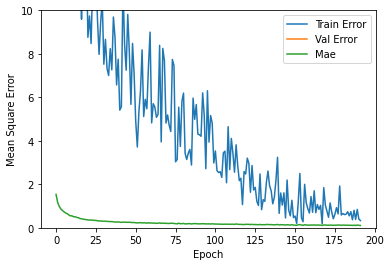

In [300]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
  plt.plot(hist['epoch'], hist['mae'], label='Mae')
  plt.ylim([0, 10])
  plt.legend()
  plt.show()

plot_history(history)

In [302]:
model.evaluate(np.asarray(normed_test_data), np.asarray(test_labels))

40/40 [==============================] - 0s 2ms/step - loss: 0.6943 - mae: 0.6985 - mse: 1.7788


[0.6942867040634155, 0.6984777450561523, 1.7787882089614868]

In [303]:
dataset[dataset['display_name'].str.contains('hummus')]

,index,is_water,requires_age_check,display_name,unit_size,unit_price,size_format__kg,size_format__l,size_format__m,size_format__ud,packaging__1/2 pieza,packaging__bandeja,packaging__barra,packaging__benjamín,packaging__bol,packaging__bolsa,packaging__bote,packaging__botella,packaging__botellín,packaging__brick,packaging__caja,packaging__cubo,packaging__frasco,packaging__garrafa,packaging__granel,packaging__lata,packaging__malla,packaging__manojo,packaging__otro,packaging__pack-10,packaging__pack-12,packaging__pack-16,packaging__pack-2,packaging__pack-24,packaging__pack-3,packaging__pack-4,packaging__pack-6,packaging__pack-8,packaging__pack-9,packaging__paquete,packaging__pastilla,packaging__pieza,packaging__rollo,packaging__saco,packaging__sobre,packaging__spray,packaging__tableta,packaging__tarrina,packaging__tarrito,packaging__tarro,packaging__tubo,packaging__vaso
6075,6134,0,0,hummus de garbanzos simply greek receta clásica,0.24,1.39,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6076,6135,0,0,hummus de garbanzos simply greek con olivas de...,0.15,1.35,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6077,6136,0,0,hummus de garbanzos simply greek receta clásica,0.48,2.29,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6078,6137,0,0,hummus de garbanzos simply greek con pimiento ...,0.24,1.60,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6080,6139,0,0,hummus de lentejas simply greek,0.24,1.39,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [332]:
dataset[dataset['display_name'].str.contains('aceite de oliva intenso')]

,index,is_water,requires_age_check,display_name,unit_size,unit_price,size_format__kg,size_format__l,size_format__m,size_format__ud,packaging__1/2 pieza,packaging__bandeja,packaging__barra,packaging__benjamín,packaging__bol,packaging__bolsa,packaging__bote,packaging__botella,packaging__botellín,packaging__brick,packaging__caja,packaging__cubo,packaging__frasco,packaging__garrafa,packaging__granel,packaging__lata,packaging__malla,packaging__manojo,packaging__otro,packaging__pack-10,packaging__pack-12,packaging__pack-16,packaging__pack-2,packaging__pack-24,packaging__pack-3,packaging__pack-4,packaging__pack-6,packaging__pack-8,packaging__pack-9,packaging__paquete,packaging__pastilla,packaging__pieza,packaging__rollo,packaging__saco,packaging__sobre,packaging__spray,packaging__tableta,packaging__tarrina,packaging__tarrito,packaging__tarro,packaging__tubo,packaging__vaso
2,2,0,0,aceite de oliva intenso hacendado,1.0,3.90,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0,0,aceite de oliva intenso hacendado,3.0,10.95,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [305]:
test_dataset.tail(1)

,is_water,requires_age_check,unit_size,size_format__kg,size_format__l,size_format__m,size_format__ud,packaging__1/2 pieza,packaging__bandeja,packaging__barra,packaging__benjamín,packaging__bol,packaging__bolsa,packaging__bote,packaging__botella,packaging__botellín,packaging__brick,packaging__caja,packaging__cubo,packaging__frasco,packaging__garrafa,packaging__granel,packaging__lata,packaging__malla,packaging__manojo,packaging__otro,packaging__pack-10,packaging__pack-12,packaging__pack-16,packaging__pack-2,packaging__pack-24,packaging__pack-3,packaging__pack-4,packaging__pack-6,packaging__pack-8,packaging__pack-9,packaging__paquete,packaging__pastilla,packaging__pieza,packaging__rollo,...,4383,4384,4385,4386,4387,4388,4389,4390,4391,4392,4393,4394,4395,4396,4397,4398,4399,4400,4401,4402,4403,4404,4405,4406,4407,4408,4409,4410,4411,4412,4413,4414,4415,4416,4417,4418,4419,4420,4421,4422
6343,0,0,0.8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# TODO: esta función solo sirve para productos que se miden en KG.
def initialize_product(product_name, size, isWater, requires_age_check, currentPackaging):
  product_name = remove_some_words(product_name)
  product = pd.DataFrame.from_records(vectorizer.transform([product_name]).toarray())
  product.insert(0, 'is_water', isWater)
  product.insert(1, 'requires_age_check', requires_age_check)
  product.insert(2, 'unit_size', size)
  product.insert(3, 'size_format__kg', 1)
  product.insert(4, 'size_format__l', 0)
  product.insert(5, 'size_format__m', 0)
  product.insert(6, 'size_format__ud', 0)
  j = 7
  for i in list_packagings:
    val = (currentPackaging == i)*1.0
    product.insert(j,'packaging__' + i, val)
    j = j+1
  return norm(product)

In [351]:
isWater = 0
requires_age_check = 0
h = initialize_product('hummus de chocolate', 0.24, isWater, requires_age_check, 'tarrina')
model.predict(h)

array([[1.9500829]], dtype=float32)

In [352]:
h = initialize_product('hummus de chocolate hacendado', 0.24, isWater, requires_age_check, 'tarrina')
model.predict(h)

array([[1.5295836]], dtype=float32)

In [353]:
h = initialize_product('hummus de chocolate hacendado', 0.15, isWater, requires_age_check, 'tarrina') # vista foto en internet: 150gr = 1.60 €.
model.predict(h)

array([[1.4049431]], dtype=float32)

In [354]:
h = initialize_product('hummus de chocolate nestlé', 0.24, isWater, requires_age_check, 'tarrina')
model.predict(h)

array([[2.2704391]], dtype=float32)

In [355]:
h = initialize_product('rodaja de emperador caladero', 0.4, isWater, requires_age_check, 'bandeja') # precio real 6.18 €
model.predict(h)

array([[6.170108]], dtype=float32)

In [356]:
h = initialize_product('hummus de garbanzos simply greek receta clásica', 0.24, isWater, requires_age_check, 'tarrina') # precio real 1.39 €.
model.predict(h)

array([[1.3587986]], dtype=float32)